# Project: 제32회 ADP 실기 대비 - 핵심만 요약한 통계와 머신러닝 파이썬 코드북

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

- 시계열 분석(Time Series Analysis)이란, 시간 순서대로 정렬된 데이터에서 의미 있는 요약과 통계 정보를 추출하는 것이다. 과거 행동을 진단할 뿐만 아니라 미래 행동을 예측하기 위해 시계열 분석을 수행한다.
- 시계열 데이터는 시간의 흐름에 따라 서로 연결된 형태여야 하고 되도록 규칙적인 간격으로 수집해야 한다.
- 시계열의 종류는 일변량 시계열과 다변량 시계열이 있다. 일변량 시계열(Univariate)은 시간에 대해 측정된 변수가 하나만 있는 경우이고, 다변량(Multivariate)은 각 타임스탬프에서 측정된 변수가 여러 개인 경우를 의미한다.
- 측정된 여러 변수가 서로 연관되거나 각 변수가 서로 시간 종속성을 가지는 시계열은 다채로운 분석이 가능하다.

In [18]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv").filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') # 날짜 데이터로 설정
ts = ts.set_index('날짜') # 인덱스를 날짜로 셋팅
ts_head = ts.head(334) # 2021년 1~11월 데이터
ts_tail = ts.tail(31)  # 2021년 12월 데이터

ts_head.head(3)

,전일대비증감수
날짜,
2021-01-01,357
2021-01-02,250
2021-01-03,198


## 12-1. 시계열 탐색적 분석

### 12-1-1. 일반적 EDA
- 일반적 EDA 중 하나는 히스토그램을 그리는 것이다.
- 실제 측정치 자체에 대한 히스토그램을 그려볼 수도 있지만, 시계열에서 더 주목하는 부분은 한 측정치가 다음 측정치로 변화한 정도이다.
- 따라서 차분(Differencing)함으로써 추세가 제거된 데이터를 히스토그램으로 그려 탐색적 분석을 실시할 수 있다.
- 산점도도 그려볼 수 있다. x축을 시간, y축을 한 측정치가 다음 측정치로 변화한 정도로 놓고 시간과 변화량의 관계를 확인하거나, x축을 시간, y축에 두 변량의 측정치로 산점도를 그려서 시간 변화에 따른 두 변량의 연관성을 확인해 볼 수도 있다.
- 이 밖에 관찰값의 요약통계량을 확인하는 방법이 있다.

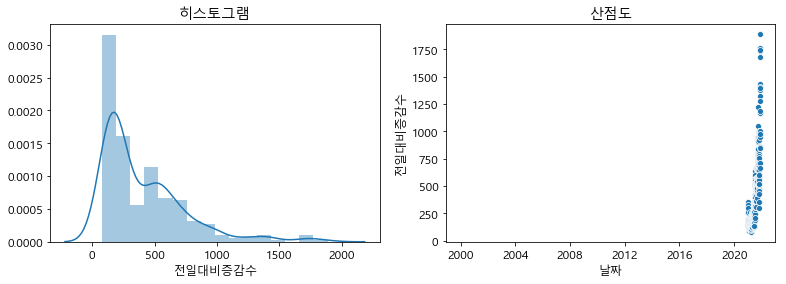


 [요약통계량]
         count        mean         std   min    25%    50%    75%     max
전일대비증감수  334.0  405.152695  336.013188  79.0  152.0  252.5  556.0  1888.0


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# 일단, 차분없는 원본 시계열로 EDA 진행

# 히스토그램
axes[0].set_title("히스토그램")
sns.distplot(ts_head['전일대비증감수'], ax=axes[0])

# 산점도
axes[1].set_title("산점도")
sns.scatterplot(x='날짜', y='전일대비증감수', data=ts_head, ax=axes[1])
plt.show()

# 요약 통계량
print("\n [요약통계량]")
print(ts_head.describe().T)

### 12-1-2. 시계열에 특화된 EDA

#### 정상성 확인
- 전통적인 시계열 모델은 정상 시계열 데이터를 전제로 한다.
- 정상 시계열은, 정상성(Stationarity)을 가지는 시계열로서 시간이 지나더라도 평균과 분산이 일정하고 추세나 계절성을 가지지 않는다.
- 시계열의 정상성을 확인하는 방법은 ADF(Augmented Dickey-Fuller) 검정, KPSS(Kwiatowski-Philips-Schmidt-Shin)검정, ACF 그래프 등이 있다.
- ADF 검정은 '단위근(Unit root)이 있다'를 귀무가설로, '단위근이 없다'를 대립가설로 검정을 실시한다.
- 검정 결과 대립가설을 채택하여 단위근이 없는 시계열을 정상 시계열로 본다.
- KPSS 검정은 ADF와는 반대로 '정상 시계열이다'를 귀무가설로, '비정상 시계열이다'를 대립가설로 설정하고 검정을 실시한다.
- 검정 결과 귀무가설을 기각하지 않을 경우 정상 시계열로 본다.
- 정상 데이터의 ACF 그래프는 시차(Time lag)가 증가할수록 0으로 빠르게 떨어지고, 비정상성(Non-stationarity) 데이터의 ACF 그래프는 느리게 감소한다.

- 정상화 방법
  - 시계열을 정상화하기 위한 방법으로, 평균이 일정하지 않은 경우는 데이터를 차분(Differencing)하고, 분산이 변화하는 경우는 데이터를 변환(Transformation)한다.
  - 변환에는 로그 변환, 제곱근 변환, Box-cox, Yeo-Johnson 변환 등이 있다.
  - 차분과 변환 예제는 <12-2. 시계열 데이터 전처리>의 차분과 변환에서 다루기로 한다.

In [19]:
# 정상성 검정1 - ADF
# H0: 단위근을 포함한다 (비정상)
# H1: 단위근을 포함하지 않는다 (정상)

from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_head, regression='c', autolag='AIC')

# ts_head가 비정상 시계열이라는 결론을 얻었다.
print(f"ADF Statistics: {result[0]}, p-value: {result[1]}")

ADF Statistics: 0.7623135388299556, p-value: 0.9910028277484191


In [20]:
# 정상성 검정2 - KPSS
# H0: 정상 시계열과 차이가 없다 (정상)
# H1: 정상 시계열과 차이가 있다 (비정상)

from statsmodels.tsa.stattools import kpss
result = kpss(ts_head, regression='c', nlags='auto')

# ts_head가 비정상 시계열이라는 결론
print(f"KPSS Statistics: {result[0]}, p-values: {result[1]}")

KPSS Statistics: 2.20981855108106, p-values: 0.01


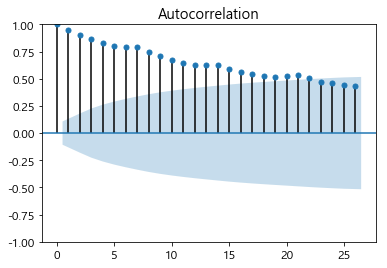

In [21]:
# 정상성 검정3 - ACF 그래프
from statsmodels.graphics.tsaplots import plot_acf

# 시차에 따라 값이 빠르게 떨어지지 않기 때문에 비정상 시계열이라는 결론
plot_acf(ts_head)
plt.show()

#### 자기상관 확인
- 자기상관(Autocorrelation)이란 서로 다른 시점의 데이터 간의 선형적 상관관계를 의미하며, 이를 확인하기 위해 자기상관함수(ACF, Autocorrelation function)와 편자기상관함수(PACF, Partial autocorrelation function) 그래프를 그리거나 융박스 검정(Ljung-box test), 더빈왓슨(Durbin-watson) 검정을 진행한다.
- ACF는 lag에 따른 관측치들 사이의 관련성을 측정하는 함수이고, x축에 시차, y축에 자기상관계수를 놓은 ACF 그래프에서 y값이 임계영역(Critical region)에서 벗어나는 경우가 있으면 자기상관이 있다고 본다.
- PACF는 k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 $y_t$와 $y_{t-k}$의 관련성을 측정하는 함수이다. PACF 그래프를 통해 어느 시차의 데이터와 자기상관을 가지는지 확인할 수 있다.
- 융박스 검정의 귀무가설은 '자기상관이 없다'이고, 대립가설은 '자기상관이 있다'이다.
- 더빈왓슨 검정은 더빈왓슨 통계량이 2에 가까울수록 자기상관이 없고, 0에 가까울수록 양의 상관관계, 4에 가까울수록 음의 상관관계를 가진다.

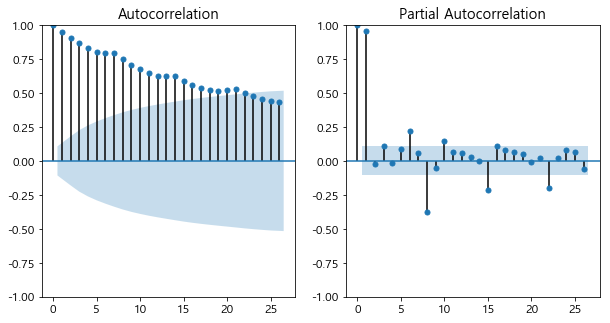

0시차: 자기상관계수 1.0, 신뢰구간 1.0 ~ 1.0
1시차: 자기상관계수 0.9536990865996833, 신뢰구간 0.8464546288657142 ~ 1.0609435443336523
2시차: 자기상관계수 0.9072631898152989, 신뢰구간 0.7271983753294583 ~ 1.0873280043011395
3시차: 자기상관계수 0.8730241969439313, 신뢰구간 0.646402246779489 ~ 1.0996461471083736


In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

# 자기상관검정1 - ACF/PACF 그래프
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(ts_head, ax=ax[0])  # ACF  그래프의 임계영역을 벗어나는 값들을 볼 때, 자기 상관이 있음을 알 수 있다.
plot_pacf(ts_head, ax=ax[1]) # PACF 그래프의 임계영역을 벗어나는 시차 1, 3, 6, 8 등이 자기 상관이 있음을 알 수 있다.
plt.show()

# 시차별 자기상관계수와 자기상관계수가 0이라는 95% 신뢰구간(아래 음영)도 구할 수 있다.
ACs, confs = acf(ts_head, fft=False, nlags=3, alpha=0.05, adjusted=True)
for lag, ac, conf in zip(range(3+1), ACs, confs):
  print(f"{lag}시차: 자기상관계수 {ac}, 신뢰구간 {conf[0]} ~ {conf[1]}")

In [23]:
# 자기상관검정2 - Ljung-box test
# H0: 데이터가 일련의 상관관계를 나타내지 않는다.
# H1: 데이터가 일련의 상관관계를 나타낸다.
from statsmodels.stats.diagnostic import acorr_ljungbox

print("융박스 테스트")
result = acorr_ljungbox(ts_head, return_df=True, auto_lag=True)
result.head(3) # ts_head가 자기상관이 있다는 결론을 얻었다.

융박스 테스트


,lb_stat,lb_pvalue
1,304.691106,3.131578e-68
2,579.605498,1.381228e-126
3,833.394832,2.474556e-180


In [24]:
# 자기상관검정3 - Durbin-watson test
# 통계량이 2에 가까우면 자기 상관이 없다.
# 통계량이 0 혹은 4에 가까우면 자기 상관이 있다.
from statsmodels.stats.stattools import durbin_watson
result = durbin_watson(ts_head)
result # ts_head가 자기상관이 있다는 결론을 얻었다.

array([0.03337102])

#### 시계열 분해
- 시계열 분해(Time-series decomposition)를 통해 시계열 데이터를 추세(Trend variation), 계절성(Seasonal variation), 순환(=주기, Cycle variation), 불규칙 변동(Irregular variation)으로 분해하고 각각을 살펴봄으로써 데이터를 쉽게 파악하고, 에측에도 활용할 수 있다.
- 시계열 분해 방법으로는 이동평균법, 지수평활법, STL 분해 등이 있다.
- 이동평균법(Moving average)을 통해서 시계열 데이터를 일정 기간 별 이동평균을 계산함으로써 계절 변동과 불규칙 변동을 제거하고 추세 변동과 순환 변동만 가진 시계열로 분해할 수 있다.
- Pandas의 DataFrame으로 생성한 데이터에 rolling window와 expanding window를 통해 이동평균법을 적용할 수 있다.
- 주요 파라미터로 window(평균할 데이터의 개수)와 min_periods(이동평균을 계산하기 위한 window 내 데이터의 최소 개수)가 있다.
- 한편, 평균 외에도 max, min, sum, var, corr 등을 통해 다양한 방식으로 집계가 가능하다.
- STL 분해(Seasonal and trend decomposition using loess)를 통해 데이터를 계절 변동, 추세 변동, 잔차로 분해하여 각각 살펴볼 수 있다.

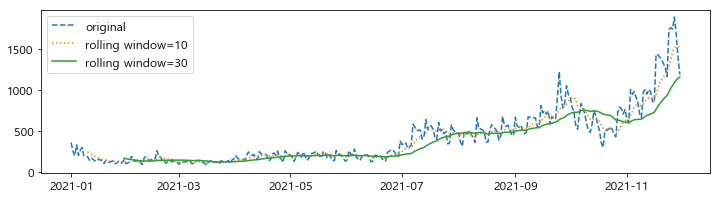

In [25]:
# 이동평균법: 계절 변동과 불규칙 변동 제거
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

titles = ['original', 'rolling window=10', 'rolling window=30']
rw10 = ts_head.rolling(window=10).mean().dropna()
rw30 = ts_head.rolling(window=30).mean().dropna()

data_list = [ts_head, rw10, rw30]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
  ax.plot(data, label=title, linestyle=ls)

plt.legend()
plt.show()

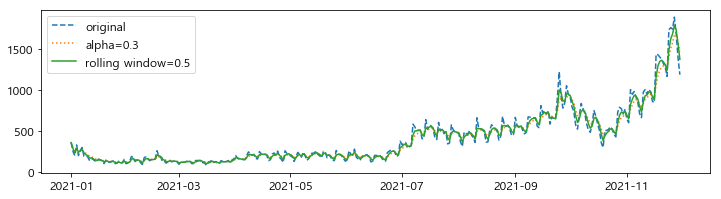

In [26]:
# 지수평활법: 불규칙변동 제거
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

titles = ['original', 'alpha=0.3', 'rolling window=0.5']
ewm03 = ts_head.ewm(alpha=0.3).mean()
ewm05 = ts_head.ewm(alpha=0.5).mean()

data_list = [ts_head, ewm03, ewm05]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
  ax.plot(data, label=title, linestyle=ls)

plt.legend()
plt.show()

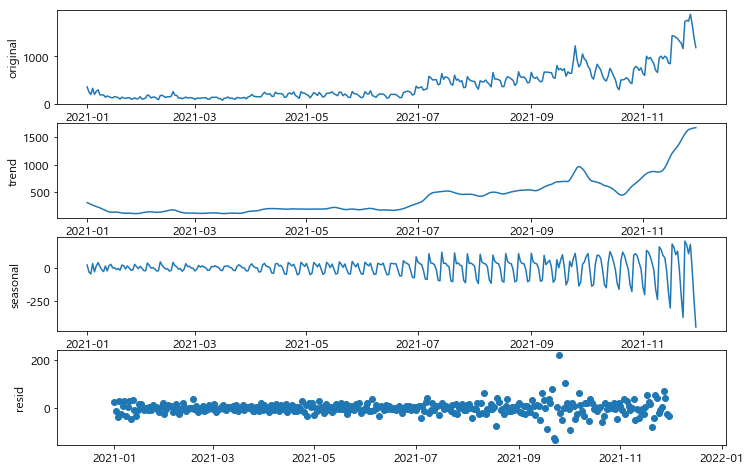

In [27]:
# STL 분해
from statsmodels.tsa.seasonal import STL

# seasonal = Length of the seasonal smoother
# trend    = Length of the trend smoother

fitted = STL(ts_head, seasonal=7, trend=9).fit()
resid = fitted.resid # 잔차
seasonal = fitted.seasonal # 추정된 계절 요소
trend = fitted.trend # 추정된 트렌드 요소

titles = ['original', 'trend', 'seasonal', 'resid']
data_list = [ts_head, trend, seasonal, resid]

fig, axes = plt.subplots(4, 1, figsize=(12, 8))

for title, data, ax in zip(titles, data_list, axes):
  ax.set_ylabel(title)
  if title != 'resid':
    ax.plot(data)
  else:
    ax.scatter(x=data.index, y=data.values)

plt.show()

## 12-2. 시계열 데이터 전처리

### 시계열 데이터 다루기
- 처음 시계열 데이터를 불러오면 데이터 타입이 날짜(datetime)가 아닌 경우(object, string 등)가 많다.
- 날짜 데이터 형태를 변환하거나 신규 날짜를 생성하거나 날짜들 간에 연산을 하기 위해서는 시계열 데이터의 날짜가 반드시 날짜(datetime) 타입으로 되어있어야 한다.
- 이를 위해 datetime, Pandas, time 라이브러리를 사용하게 된다.
  - 날짜 데이터로 타입 변경하기: object, string, timestamp 타입의 데이터를 datetime 타입의 데이터로 상호 변경할 수 있다.
  - 날짜 데이터 생성하기: 연월일 등 시간 정보를 지정해서 개별 날짜 데이터를 만들거나, 일정 기간의 날짜 데이터 리스트를 생성할 수 있다.
  - 날짜 데이터의 형태, 값 변경하기: 시간 정보의 형태와 그 값을 변경할 수 있다.
  - 날짜 데이터 간 연산하기
  - 년, 월, 일, 요일명, 요일 인덱스 추출하기

In [28]:
import datetime as dt
import pandas as pd
import time

ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv")

# 날짜 데이터로 타입 변경하기 (1) object - datetime
print(f"object: {ts['날짜'].dtypes}")
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
print(f"object to datetime: {ts['날짜'].dtypes}")

# 날짜 데이터로 타입 변경하기 (2) string - datetime
string = '2018-09-13 22:39:04'
print(f"string: {type(string)}")

# string에서 나타내는 년월일 정보와 대응하도록 format을 적어줘야 해당 날짜로 인식 가능
datetime = dt.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
print(f"string to datetime: {type(datetime)}")

string2 = datetime.strftime("%Y-%m-%d %H:%M:%S")
print(f"datetime to string: {type(string2)}")

# 날짜 데이터로 타입 변경하기 (3) timestamp - datetime
timestamp = 2551780740
datetime = dt.datetime.fromtimestamp(timestamp) # 로컬 기준
utcdatetime = dt.datetime.utcfromtimestamp(timestamp) # UTC 기준
timestamp2 = time.mktime(datetime.timetuple())

print(f"timestamp to local datetime (utc datetime): {datetime} ({utcdatetime})")
print(f"datetime to timestamp: {timestamp2}")

object: object
object to datetime: datetime64[ns]
string: <class 'str'>
string to datetime: <class 'datetime.datetime'>
datetime to string: <class 'str'>
timestamp to local datetime (utc datetime): 2050-11-11 20:59:00 (2050-11-11 11:59:00)
datetime to timestamp: 2551780740.0


In [29]:
# 날짜 데이터 생성하기 - (1) dt.datetime
date1 = dt.datetime(2023, 3, 20, 16, 0, 0) # year, monnth, day, hour, minute, second, ...

date2 = dt.datetime.now()
date_only = dt.date(2019, 1, 1)
time_only = dt.time(10, 0, 5)

print(f"직접 지정해서 만든 날짜 데이터: {date1}")
print(f"현재 시간을 반환하는 날짜 데이터: {date2}")
print(f"date only: {date_only}")
print(f"time only: {time_only}")

직접 지정해서 만든 날짜 데이터: 2023-03-20 16:00:00
현재 시간을 반환하는 날짜 데이터: 2024-04-10 19:02:30.951150
date only: 2019-01-01
time only: 10:00:05


In [30]:
# 날짜 데이터 생성하기 - (2) pd.date_range, pd.period_range
# 시작날짜, 종료날짜, 날짜 개수(periods), 날짜의 간격 단위(freq)를 입력
# freq = {'A(년)', 'M(월)', 'D(일)', 'T=min(분)', 'S(초)', 'Q(분기)', 'W(주)'}

date_list1 = pd.date_range('2016-01-01', periods=3, freq='D')
date_list2 = pd.date_range('2016-01-01', periods=4, freq='W')
date_list3 = pd.date_range('2016-01-01', '2016-01-02', freq='30T') # 시간은 60T

print(f"일 단위 날짜들 3개: {date_list1}")
print(f"주 단위 날짜들 4개: {date_list2}")
print(f"시작-종료날짜 사이 30분 단위 날짜들: {date_list3[:2]}")

date_list4 = pd.period_range('2012-01-01', freq='A', periods=2)
date_list5 = pd.period_range('2012-01-01', freq='Q', periods=3)

print(f"년 단위 날짜들 2개: {date_list4}")
print(f"분기 단위 날짜들 3개: {date_list5}")

일 단위 날짜들 3개: DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03'], dtype='datetime64[ns]', freq='D')
주 단위 날짜들 4개: DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24'], dtype='datetime64[ns]', freq='W-SUN')
시작-종료날짜 사이 30분 단위 날짜들: DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 00:30:00'], dtype='datetime64[ns]', freq='30T')
년 단위 날짜들 2개: PeriodIndex(['2012', '2013'], dtype='period[A-DEC]', freq='A-DEC')
분기 단위 날짜들 3개: PeriodIndex(['2012Q1', '2012Q2', '2012Q3'], dtype='period[Q-DEC]', freq='Q-DEC')


In [34]:
# 날짜 데이터의 형태, 값 변경하기
date3 = dt.datetime(2023, 3, 20, 0, 1, 10)
date3_c1 = date3.strftime('%Y-%m-%d') # 네 자리 년도, 월, 일
date3_c2 = date3.strftime('%y-%m-%d %H:%M') # 두 자리 년도, 월, 일, 시간, 분

print(f"형태 변경 전: {date3}")
print(f"형태 변경 후 1: {date3_c1}")
print(f"형태 변경 후 2: {date3_c2}")

date4 = date3.replace(year=2022, minute=2)
print(f"값 변경 전: {date3}")
print(f"값 변경 후: {date4}")

date_only = dt.date(2019, 1, 1)
time_only = dt.time(10, 0, 5)
datetime = dt.datetime.combine(date_only, time_only)
print(f"값 병합 전: {date_only} {time_only}")
print(f"값 병합 후: {datetime}")

형태 변경 전: 2023-03-20 00:01:10
형태 변경 후 1: 2023-03-20
형태 변경 후 2: 23-03-20 00:01
값 변경 전: 2023-03-20 00:01:10
값 변경 후: 2022-03-20 00:02:10
값 병합 전: 2019-01-01 10:00:05
값 병합 후: 2019-01-01 10:00:05


In [35]:
# 날짜 데이터 간 연산하기
# weeks, days, hours, minutes, ...

weeks1 = dt.timedelta(weeks=1)
today = dt.date(2023, 2, 10)

print(f"오늘: {today}")
print(f"오늘로부터 1주 전: {today - weeks1}")
print(f"오늘로부터 1주 후: {today + weeks1}")

오늘: 2023-02-10
오늘로부터 1주 전: 2023-02-03
오늘로부터 1주 후: 2023-02-17


In [36]:
# 년, 월, 일, 요일명, 요일인덱스 추출하기
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') # 날짜의 데이터 타입 변경
ts['년'] = ts['날짜'].dt.year # 날짜 feature에서 년 정보를 추출
ts['월'] = ts['날짜'].dt.month
ts['일'] = ts['날짜'].dt.day
ts['요일1'] = ts['날짜'].dt.weekday    # 0~6 (월요일~일요일)
ts['요일2'] = ts['날짜'].dt.day_name() # 영어 요일명

ts.filter(['날짜', '년', '월', '일', '요일1', '요일2']).head()

,날짜,년,월,일,요일1,요일2
0,2021-01-01,2021,1,1,4,Friday
1,2021-01-02,2021,1,2,5,Saturday
2,2021-01-03,2021,1,3,6,Sunday
3,2021-01-04,2021,1,4,0,Monday
4,2021-01-05,2021,1,5,1,Tuesday


#### 시계열 빈도 변경 (업샘플링, 다운샘플링)
- 시계열 데이터들의 날짜 빈도를 늘리는 것을 업샘플링(Up-sampling), 줄이는 것을 다운샘플링(Down-sampling)이라고 한다.
- 불규칙적으로 샘플링된 시계열 데이터를 규칙적인 형태로 변환하거나, 현재 샘플링된 것보다 더 높은 빈도로 변환할 필요가 있을 때 업샘플링을 하고, 원본 데이터의 시간 단위가 너무 작아서 실용적이지 않거나 현재 샘플링된 것보다 더 낮은 빈도로 변환할 필요가 있을 때 다운샘플링을 한다.
- 이러한 리샘플링(Re-sampling)은 Pandas로 간편하게 진행할 수 있다.

In [37]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv")

# 날짜 column의 데이터 타입을 변경하고 인덱스로 셋팅한다.
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
ts = ts.set_index('날짜')

In [38]:
# rule = 'A(년), M(월), D(일), T=min(분), S(초), Q(분기), W(주)'
# aggregating = .asfreq(), .sum(), .mean()
ts.resample(rule='Q').asfreq()

,누적확진자수,전일대비증감수
날짜,,
2021-03-31,32029,158
2021-06-30,49986,375
2021-09-30,100492,945
2021-12-31,225235,1670


In [39]:
ts.resample(rule='Q').sum()

,누적확진자수,전일대비증감수
날짜,,
2021-03-31,2357075,13034
2021-06-30,3726692,17957
2021-09-30,6672971,50508
2021-12-31,13440595,124799


In [40]:
ts.resample(rule='Q').mean()

,누적확진자수,전일대비증감수
날짜,,
2021-03-31,26189.722222,144.822222
2021-06-30,40952.659341,197.329670
2021-09-30,72532.293478,549.000000
2021-12-31,146093.423913,1356.510870


#### 결측치 처리
- 시계열 데이터의 결측치를 채우는 방법으로 forward fill, backward fill, 이동 평균(Moving average), 보간법(Interpolation) 등이 있다.
- forward fill은 누락된 값이 나타나기 직전의 값으로 누락된 값을 채우는 가장 간단한 방법이다.
  - 계산이 복잡하지 않고 실시간 데이터에 쉽게 적용할 수 있다.
- backward fill은 누락된 값이 나타난 직후의 값으로 누락된 값을 채우는 방법이다.
  - 하지만 이는 사전관찰이기 때문에 데이터를 사용하여 미래를 예측하지 않거나 특정 분야의 지식에 기반하여 데이터의 미래보다 과거를 채우는게 더 의미가 있는 경우에만 사용해야 한다.
- 이동 평균으로도 데이터를 대치할 수 있다. 롤링(Rolling) 평균으로도 알려진 이 값은 과거의 값으로 미래의 값을 예측한다는 관점에서 보면 forward fill과 유사하다. 하지만 이동 평균은 최근 과거의 여러 시간대를 일력한 내용을 사용한다는 점에서 다르다. 평균을 내는 방법은 모든 데이터의 가중치를 동일하게 두는 산술평균 방법과 최근 데이터에 더 높은 가중치를 두는 지수가중 이동평균(Exponentially weighted moving average)이 있다.
- 보간법은 인접한 데이터를 사용하여 누락된 데이터를 추정하는 방법이다. Pandas의 interpolate은 선형 보간법(Linear), 2차 스플라인 보간법(Quadratic spline), 3차 스플라인 보간법(Cubic spline), 다항식 보간법(Polynomial) 등이 있다. polynomial과 spline의 경우, method와 함께 차수(Order)도 지정해야 한다.
  - 형태: df.interpolate(method=, order=, ...)
  - method: 'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'polynomial', ...


In [41]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv").filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64[ns]')
ts = ts.set_index('날짜')
print(f"결측치 확인: {ts.isna().sum()}")

결측치 확인: 전일대비증감수    0
dtype: int64


In [42]:
# 결측치 있는 데이터로 만들기
ts_na = ts.copy()

import numpy as np
random_numbers = np.random.randint(0, len(ts)-1, 50)
for num in random_numbers:
  ts_na.iloc[num, :] = np.nan

print(f"결측치 확인: {ts_na.isna().sum()}")

결측치 확인: 전일대비증감수    46
dtype: int64


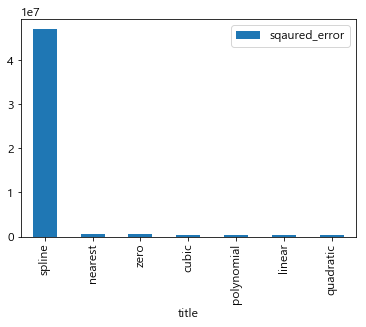

In [43]:
# 각종 보간 후 실제 데이터와 비교
linear = ts_na.interpolate(method='linear')
nearest = ts_na.interpolate(method='nearest')
zero = ts_na.interpolate(method='zero')
quadratic = ts_na.interpolate(method='quadratic') # polynomial order=2와 동일
cubic = ts_na.interpolate(method='cubic') # polynomial order=3과 동일
spline = ts_na.interpolate(method='spline', order=2)
polynomial = ts_na.interpolate(method='polynomial', order=3)

titles = ['linear', 'nearest', 'zero', 'quadratic', 'cubic', 'spline', 'polynomial']
data_list = [linear, nearest, zero, quadratic, cubic, spline, polynomial]
sqrd_error = []

for title, data in zip(titles, data_list):
  sqrd_e = sum((ts-data)['전일대비증감수']**2)
  sqrd_error.append(int(sqrd_e))

result = pd.DataFrame({'title' : titles, 'error' : sqrd_error}).sort_values(by='error', ascending=False)

# 보간별 법 에러 비교
result.plot.bar(x='title', y='error', label='sqaured_error')
plt.show()

#### 차분과 변환
- 탐색적 분석 단계에서 시계열 데이터가 정상성을 가지지 않는 것으로 확인된 경우, 차분과 변환을 통한 데이터 전처리가 필요하다.
- 전통적인 시계열 모델은 정상 시계열 데이터를 전제로 하기 때문이다.

original: ADF p-value: 0.9910028277484191, KPSS p-value: 0.01
diff(1): ADF p-value: 0.003625351225510241, KPSS p-value: 0.1
diff(2): ADF p-value: 0.004660529794714215, KPSS p-value: 0.1


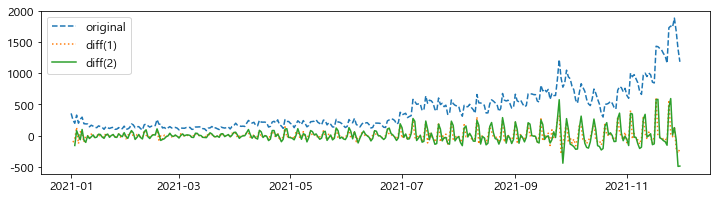

In [44]:
ts = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/12_covid19.csv").filter(['날짜', '전일대비증감수'])
ts['날짜'] = ts['날짜'].astype('datetime64[ns]') # 날짜 데이터로 설정
ts = ts.set_index('날짜') # 인덱스를 날짜로 셋팅

ts_head = ts.head(334) # 2021년 1~11월 데이터
ts_tail = ts.tail(31)  # 2021년 12월 데이터

# 차분 전/후 비교
from statsmodels.tsa.stattools import adfuller, kpss

fig, ax = plt.subplots(1, 1, figsize=(12, 3))

titles = ['original', 'diff(1)', 'diff(2)']
diff1 = ts_head.diff(periods=1).dropna()
diff2 = ts_head.diff(periods=2).dropna()

data_list = [ts_head, diff1, diff2]
ls_list = ['dashed', 'dotted', 'solid']

for title, data, ls in zip(titles, data_list, ls_list):
  ax.plot(data, label=title, linestyle=ls)
  ap = adfuller(data)[1]
  kp = kpss(data)[1]
  print(f"{title}: ADF p-value: {ap}, KPSS p-value: {kp}")

plt.legend()
plt.show() # 1번의 차분으로 정상시계열이 되는 것을 확인

original: ADF p-value: 0.9910028277484191, KPSS p-value: 0.01
log: ADF p-value: 0.0007278939174732001, KPSS p-value: 0.1
box-cox: ADF p-value: 0.0003760395058521227, KPSS p-value: 0.1


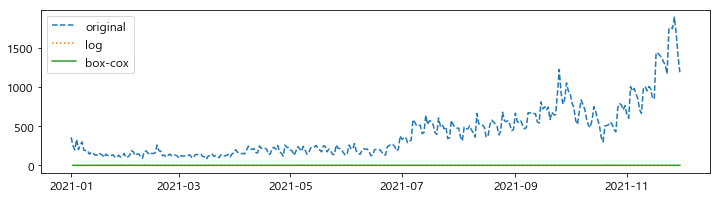

In [45]:
# 변환과 차분 전/후 비교
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import PowerTransformer

import numpy as np

# 로그 변환
log = np.log(ts_head)

# 박스콕스 변환
pt = PowerTransformer(method='box-cox')
rescaled = pt.fit_transform(ts_head)
boxcox = pd.DataFrame(rescaled, index=ts_head.index, columns=ts_head.columns)

# 차분 1회
log = log.diff(1).dropna()
boxcox = boxcox.diff(1).dropna()

# 시각화
titles = ['original', 'log', 'box-cox']
data_list = [ts_head, log, boxcox]
ls_list = ['dashed', 'dotted', 'solid']

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
for title, data, ls in zip(titles, data_list, ls_list):
  ax.plot(data, label=title, linestyle=ls)
  ap = adfuller(data)[1]
  kp = kpss(data)[1]
  print(f"{title}: ADF p-value: {ap}, KPSS p-value: {kp}")

plt.legend()
plt.show()

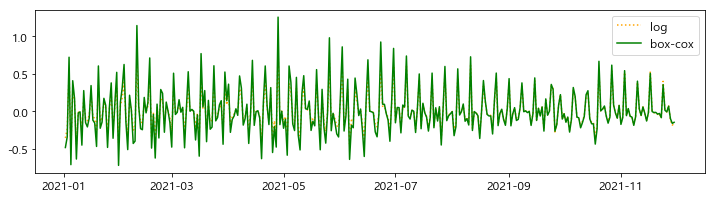

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
titles, data_list = ['log', 'box-cox'], [log, boxcox]
ls_list, c_list = ['dotted', 'solid'], ['orange', 'green']

for title, data, ls, c in zip(titles, data_list, ls_list, c_list):
  ax.plot(data, label=title, linestyle=ls, color=c)
  ap = adfuller(data)[1]
  kp = kpss(data)[1]

plt.legend()
plt.show() # log/box-cox 변환과 차분 1회로 정상시계열 확인

## 12-3. 시계열 모델링 및 평가
- 시계열 데이터를 모델링하는 방법은 통계적 접근방식과 머신러닝 접근방식이 있다. 아래에서는 통계 모델인 ARIMA의 예제를 살펴보기로 한다.
- 시계열 모델의 평가는 회귀 모델의 평가 지표와 동일하다. 회귀 모델의 평가 지표는 <11-1. 회귀모델 평가 지표>에서 자세하게 확인할 수 있다. 아래에서는 $R^2$와 MAPE로 시계열 모델들을 평가하고 비교하고자 한다.
- 시계열 통계 모델에는 자기회귀 모델(AR, Auto-regressive), 이동평균 모델(MA, Moving average), 자기회귀누적이동평균 모형(ARIMA, Auto-Regressive Integrated Moving Average), 계절성 ARIMA(SARIMA, Seasonal ARIMA) 등이 있다.
- 그 중에서도 ARIMA 모델은 자기회귀 및 이동평균 모델을 모두 포괄하는 모델이다. 이 특성은 ARMA 모델만으로도 달성될 수 있지만 추가로 추세의 제거 및 차분까지 고려한 모델이다.
- 계절성 ARIMA는 승법(Multiplicative) 계절성을 가정한다. 따라서 SARIMA 모델은 ARIMA(p, d, q) * (P, D, Q)m과 같이 표현된다. SARIMA 모델은 계절 주기당 시간 단계의 수를 정하는 m을 가진 ARIMA 과정이라고도 볼 수 있다. 이 인수의 중요한 점은 모델이 시간상 인접한 데이터가 동일한 계절 또는 서로 다른 계절에 있어도 시간적으로 근접한 일반적인 방법으로 서로의 영향을 인식한다는 것이다.

#### 박스-젠킨스(Box-Jenkins) 방법과 ARIMA
- 정상성 및 계절성: 시계열의 정상성 여부와 모델링해야 할 중요한 계절성이 있는지 확인한다.
- 정상성을 위한 작업: 차분과 변환을 진행한다.
- 적절한 차수 p와 q찾기: ACF/PACF 그래프를 통해 자기회귀(AR) 및 이동평균(MA) 항의 차수 즉, p와 q를 찾는다. AR(p)는 ACF 값이 천천히 감소하고 PACF 값은 p 이후에 빠르게 감소한다. MA(q)는 ACF 값이 q 이후에 빠르게 감소하고, PACF에서 천천히 감소한다. ARMA는 둘 다 가파른 절단이 없다.
- 앞선 p, q는 비계절성 부분에 대한 차수이고, P, Q, m이라는 계절성 차수도 염두에 둘 수 있다.
- ACF 그래프의 시차 m에서 뾰족한 막대는 있지만 다른 유의미한 뾰족한 막대가 없고, PACF 그래프의 계절성 시차가 지수적으로 감소하면 Q=1로 둘 수 있다.
- 한편, ACF 그래프의 계절성 시차가 지수적으로 감소하고, PACF 그래프의 시차 m에서 뾰족한 막대는 있지만 다른 유의미한 뾰족한 막대가 없는 경우, P=1로 둘 수 있다.
- 예측한 모델의 잔차가 자기상관이 없고, 정상성을 갖는다면, 해당 모델을 최종 ARIMA 모델로 선택할 수 있다.

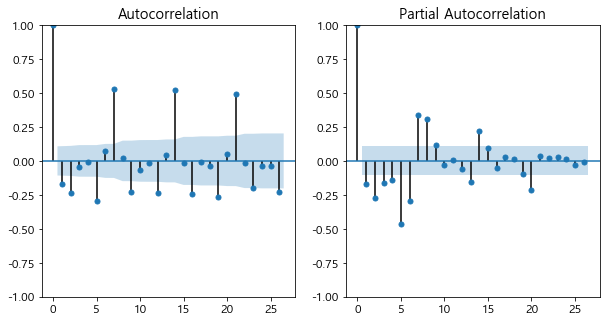

In [47]:
# 박스-젠킨스 방법
# boxcox 변환 및 차분을 통해 정상화한 시계열 데이터 'boxcox'로 적절한 차수를 찾기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(boxcox, ax=ax[0])
plot_pacf(boxcox, ax=ax[1])
plt.show() # 차수는 plot 상의 절단점을 참고하여 p=9, q=2로 정하고 모델을 적합하기로 한다. 계절성이 있는 것으로 보인다.

# 모델의 비계졀성 부분
p=9 # AR 차수
d=1 # 차분 횟수
q=2 # MA 차수

# 모델의 계절성 부분 (계절성이 없으면 생략 가능)
P=0
D=0
Q=1 # ACF lag7에서 뾰족한 막대를 가지고, PACF는 지수적으로 감소
s=7 # ACF lag7에서 뾰족한 막대를 가짐, 계절성 단위(seasonal period)

In [50]:
# 모델 예측 및 잔차 분석
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ARIMA에서 seasonal_order를 입력하면 SARIMAX와 동일한 결과를 얻음
model = ARIMA(ts_head, order=(p, d, q), seasonal_order=(P, D, Q, s)) # 원본 데이터 입력
fitted = model.fit()
resid = fitted.resid

# pred1과 pred2는 동일한 값
pred1 = fitted.forecast(31) # 이후 31개 날짜의 값을 예측
pred2 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) # 시작/종료날짜로 예측

# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면 정규성을 가진다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면 자기상관이 없다.

fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(9, 1, 2)x(0, 0, [1], 7)   Log Likelihood               -1854.019
Date:                           Wed, 10 Apr 2024   AIC                           3734.037
Time:                                   19:06:24   BIC                           3783.543
Sample:                               01-01-2021   HQIC                          3753.778
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0282      0.999     -0.028      0.977      -1.986       1.929
ar.L2         -0.1720      0.495     -0.347      0.728      -1.142       0.798
ar.L3         -0.0260      0.029     -0.912      0.362      -0.082       0.030
ar.L4         -0.0402      0.038     -1.071      0.284      -0.114       0.033
ar.L5         -0.0382      0.033     -1.155      0.248      -0.103       0.027
ar.L6         -0.0319      0.031     -1.023      0.306      -0.093       0.029
ar.L7          0.9457      0.040     23.474      0.000       0.867       1.025
ar.L8          0.0046      0.972      0.005      0.996      -1.899       1.909
ar.L9          0.1374      0.474      0.290      0.772      -0.792       1.067
ma.L1         -0.2067      0.992     -0.208      0.835      -2.151       1.738
ma.L2          0.0491      0.704      0.070      0.944      -1.331       1.429
ma.S.L7       -0.6528      0.059    -11.155      0.000      -0.768      -0.538
sigma2      4656.8753    268.160     17.366      0.000    4131.292    5182.459
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1186.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               8.50   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 자동 차수 선택 방법과 ARIMA
- 여러 조합의 차수들을 적용하여 적합한 모델의 가능도와 AIC 값을 비교한 후, 가능도(Likelihood)가 가장 높고, AIC가 가장 낮은 모델을 선택한다.
- pmdarima 모듈의 auto_arima를 사용하거나, 후보 차수 조합들을 생성한 후 반복문을 사용하여 적합한 모델의 가능도와 AIC 값을 비교할 수 있다.

In [54]:
# 자동 차수 선택1 - pmdarima의 auto_arima
from pmdarima import auto_arima

auto_arima(ts_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True, with_intercept=False)

In [57]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_head, order=(3, 1, 0), seasonal_order=(1, 0, 1, 7))

fitted = model.fit()
resid = fitted.resid
pred3 = fitted.forecast(31) # 이후 31개 날짜의 값을 예측
pred4 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1]) # 날짜 데이터로 예측

# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면 정규성을 가진다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면 자기상관이 없다.

fitted.summary() # auto_arima를 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1852.753
Date:                           Wed, 10 Apr 2024   AIC                           3717.507
Time:                                   19:12:56   BIC                           3740.355
Sample:                               01-01-2021   HQIC                          3726.618
                                    - 11-30-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2260      0.036     -6.293      0.000      -0.296      -0.156
ar.L2         -0.1731      0.039     -4.395      0.000      -0.250      -0.096
ar.L3         -0.1134      0.042     -2.691      0.007      -0.196      -0.031
ar.S.L7        0.9825      0.015     66.324      0.000       0.953       1.012
ma.S.L7       -0.6567      0.040    -16.420      0.000      -0.735      -0.578
sigma2      3830.1705    168.180     22.774      0.000    3500.543    4159.798
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               918.22
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# 자동 차수 선택2 - 반복문 사용
import itertools

p = range(0, 4)
d = range(1, 2)
q = range(0, 3)
Q = D = P = range(0, 2)
m = [4, 7, 12]
combis = list(itertools.product(p, d, q, P, D, Q, m))

dict_model = {}
for i, combi in enumerate(combis):
    try:
        no_seasonal = combi[:3]
        seasonal = combi[3:]
        model = ARIMA(ts_head, order=(no_seasonal), seasonal_order=(seasonal))
        fitted = model.fit()
        dict_model[combi] = [fitted.llf, fitted.aic]
        
        # llf(Likelihood)는 높을수록 좋음
        # AIC는 낮을수록 좋음
    except:
        print(f"except: {i}, {combi}") # LU decomposition error 발생하는 경우 pass
        continue
        
result = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'AIC']).sort_values(by='AIC', ascending=True)
result

,llf,AIC
"(1, 1, 0, 1, 0, 1, 7)",0.000000,8.000000
"(3, 1, 2, 1, 0, 1, 7)",-80.879107,177.758213
"(3, 1, 1, 0, 1, 1, 7)",-1807.948928,3627.897856
"(3, 1, 2, 0, 1, 1, 7)",-1807.944495,3629.888991
"(3, 1, 0, 0, 1, 1, 7)",-1810.092109,3630.184218
...,...,...
"(3, 1, 0, 0, 1, 0, 4)",-2067.112994,4142.225988
"(2, 1, 0, 0, 1, 0, 4)",-2086.585068,4179.170136
"(0, 1, 1, 0, 1, 0, 4)",-2088.194196,4180.388392
"(1, 1, 0, 0, 1, 0, 4)",-2088.409186,4180.818373


In [62]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_head, order=(3, 1, 1), seasonal_order=(0, 1, 1, 7))
fitted = model.fit()
resid = fitted.resid
pred5 = fitted.forecast(31)
pred6 = fitted.predict(start=ts_tail.index[0], end=ts_tail.index[-1])

# 잔차의 정규성 확인: Jarque-Bera 검정을 통해 귀무가설을 채택하면 정규성을 가진다.
# 잔차의 자기상관 확인: Ljung-Box 검정을 통해 귀무가설을 채택하면 자기상관이 없다.

# 반복문을 통해 SARIMA 모델을 적합하였으나, 잔차가 정규성을 만족하지 않기 때문에 추가적인 모델 개선이 필요하다.
fitted.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                         전일대비증감수   No. Observations:                  334
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1807.949
Date:                         Wed, 10 Apr 2024   AIC                           3627.898
Time:                                 19:20:28   BIC                           3650.619
Sample:                             01-01-2021   HQIC                          3636.965
                                  - 11-30-2021                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9659      0.108     -8.966      0.000      -1.177      -0.755
ar.L2         -0.3312      0.046     -7.160      0.000      -0.422      -0.241
ar.L3         -0.2202      0.040     -5.547      0.000      -0.298      -0.142
ma.L1          0.7542      0.113      6.685      0.000       0.533       0.975
ma.S.L7       -0.6317      0.028    -22.208      0.000      -0.687      -0.576
sigma2      3796.8386    176.203     21.548      0.000    3451.487    4142.191
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               693.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               7.24   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
# 예측 성능 비교
from sklearn.metrics import r2_score
import numpy as np

def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

titles = ['box-jenkins', 'auto_arima', 'for loop']
ts_tail1d = ts_tail.values.ravel()
preds = [pred1.values, pred3.values, pred5.values]

for title, pred in zip(titles, preds):
    r2 = r2_score(ts_tail1d, pred)
    mape = MAPE(ts_tail1d, pred)
    print(f"{title}: R2 {round(r2, 3)}, MAPE: {round(mape, 3)}")

box-jenkins: R2 -1.519, MAPE: 26.662
auto_arima: R2 -0.74, MAPE: 24.503
for loop: R2 -0.667, MAPE: 24.447


### 연습문제

#### 1. 
- 다음은 Microsoft의 주식 가격 데이터이다. 데이터는 날짜와 주식 종가로 구성되어 있다.
- 다음 데이터를 주 단위 평균 가격으로 다운샘플링 하고, 앞의 데이터 300개를 down_head, 뒤의 데이터 14개를 down_tail로 분할하시오.

In [65]:
ms = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/practice12_ms_stock.csv")
ms['Date'] = ms['Date'].astype('datetime64')
ms = ms.set_index('Date')
ms.head(3)

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55


In [67]:
down = ms.resample('W').mean()
down.head()

,Close
Date,
2015-04-05,40.505
2015-04-12,41.540
2015-04-19,41.890
2015-04-26,43.950
2015-05-03,48.710


In [68]:
down_head = down.head(300)
down_tail = down.tail(14)

#### 2.
- down_head 데이터로 탐색적 분석을 진행하시오.

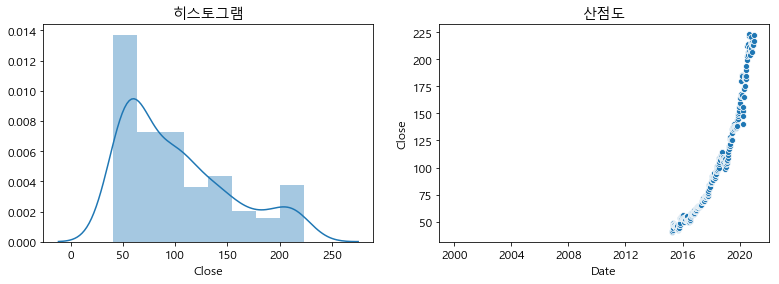

In [77]:
# 일반적인 EDA
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].set_title("히스토그램")
sns.distplot(down_head['Close'], ax=axes[0])

axes[1].set_title("산점도")
sns.scatterplot(x=down_head.index, y='Close', data=down_head, ax=axes[1])
plt.show()

In [78]:
# 요약통계량
down_head.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Close,300.0,101.73,51.32,40.5,57.51,90.93,136.58,223.2


In [81]:
# 시계열에 특화된 EDA
from statsmodels.tsa.stattools import adfuller, kpss

# ADF, KPSS 검정을 통해 시계열이 비정상임을 알 수 있다.
result = adfuller(down_head, regression='c', autolag='AIC')
print(f"ADF Statistics: {round(result[0], 3)}, p-value: {round(result[1], 3)}")

result = kpss(down_head, regression='c', nlags='auto')
print(f"KPSS Statistics: {round(result[0], 3)}, p-value: {round(result[1], 3)}")

ADF Statistics: 2.24, p-value: 0.999
KPSS Statistics: 2.593, p-value: 0.01


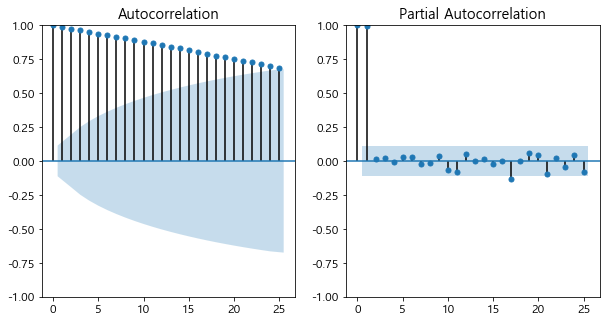

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF 그래프를 통해 시계열이 비정상임을 알 수 있으며, 자기 상관이 있는 것을 알 수 있다.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_acf(down_head, ax=ax[0])
plot_pacf(down_head, ax=ax[1])
plt.show()

In [88]:
# 융박스 테스트와 더빈왓슨 통계량을 통해 시계열이 자기 상관이 있는 것을 알 수 있다.

from statsmodels.stats.diagnostic import acorr_ljungbox

result = acorr_ljungbox(down_head, return_df=True, auto_lag=True).head(3)
print(result)

from statsmodels.stats.stattools import durbin_watson

result = durbin_watson(down_head)
print(result)

      lb_stat      lb_pvalue
1  294.753777   4.579097e-66
2  582.583051  3.116721e-127
3  863.943057  5.859132e-187
[0.00083511]


#### 3. 
- down_head 데이터로 시계열 모델을 적합하시오.

In [90]:
# 적절한 차수 모색을 위해 auto_arima를 사용
from pmdarima import auto_arima

auto_arima(down_head, start_p=1, start_q=1, max_p=5, max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5, m=7, seasonal=True, trace=False, error_action='warn', suppress_warnings=True)

ARIMA(order=(3, 1, 2), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [91]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 3, 1, 2
P, D, Q, m = 1, 0, 1, 7

model = ARIMA(down_head, order=(p, d, q), seasonal_order=(P, D, Q, m))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  300
Model:             ARIMA(3, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -770.545
Date:                           Wed, 10 Apr 2024   AIC                           1557.089
Time:                                   19:45:36   BIC                           1586.693
Sample:                               04-05-2015   HQIC                          1568.938
                                    - 12-27-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1277      0.104      1.229      0.219      -0.076       0.331
ar.L2          0.9906      0.063     15.728      0.000       0.867       1.114
ar.L3         -0.1190      0.046     -2.596      0.009      -0.209      -0.029
ma.L1         -0.0277      0.127     -0.218      0.827      -0.276       0.221
ma.L2         -0.9696      0.114     -8.503      0.000      -1.193      -0.746
ar.S.L7        0.9505      0.150      6.344      0.000       0.657       1.244
ma.S.L7       -0.8796      0.176     -5.000      0.000      -1.224      -0.535
sigma2        10.0459      0.632     15.883      0.000       8.806      11.286
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               984.38
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              14.76   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 4.
- 해당 모델로 down_tail의 기간의 값을 예측하고, 적절한 평가 지표를 선택하여 해당 모델을 평가하시오.

3.51


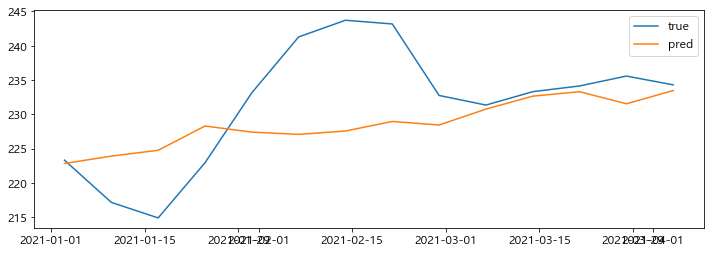

In [95]:
def MAPE(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# 해당 모델로 down_tail 데이터의 기간을 예측한 결과, MAPE 3.5%를 얻었다.
# 이는 실제값과 예측값이 평균적으로 3.5% 차이 난다는 의미이다.
 
pred = fitted.predict(start=down_tail.index[0], end=down_tail.index[-1])
print(MAPE(down_tail.values, pred.values).round(2))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(down_tail, label='true')
ax.plot(pred, label='pred')
plt.legend()
plt.show()